In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

train_set = pd.read_csv('/kaggle/input/airline-passenger-satisfaction/train.csv')
test_set = pd.read_csv('/kaggle/input/airline-passenger-satisfaction/test.csv')
df = pd.concat([train_set, test_set])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129880 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129880 non-null  int64  
 1   id                                 129880 non-null  int64  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      129880 non

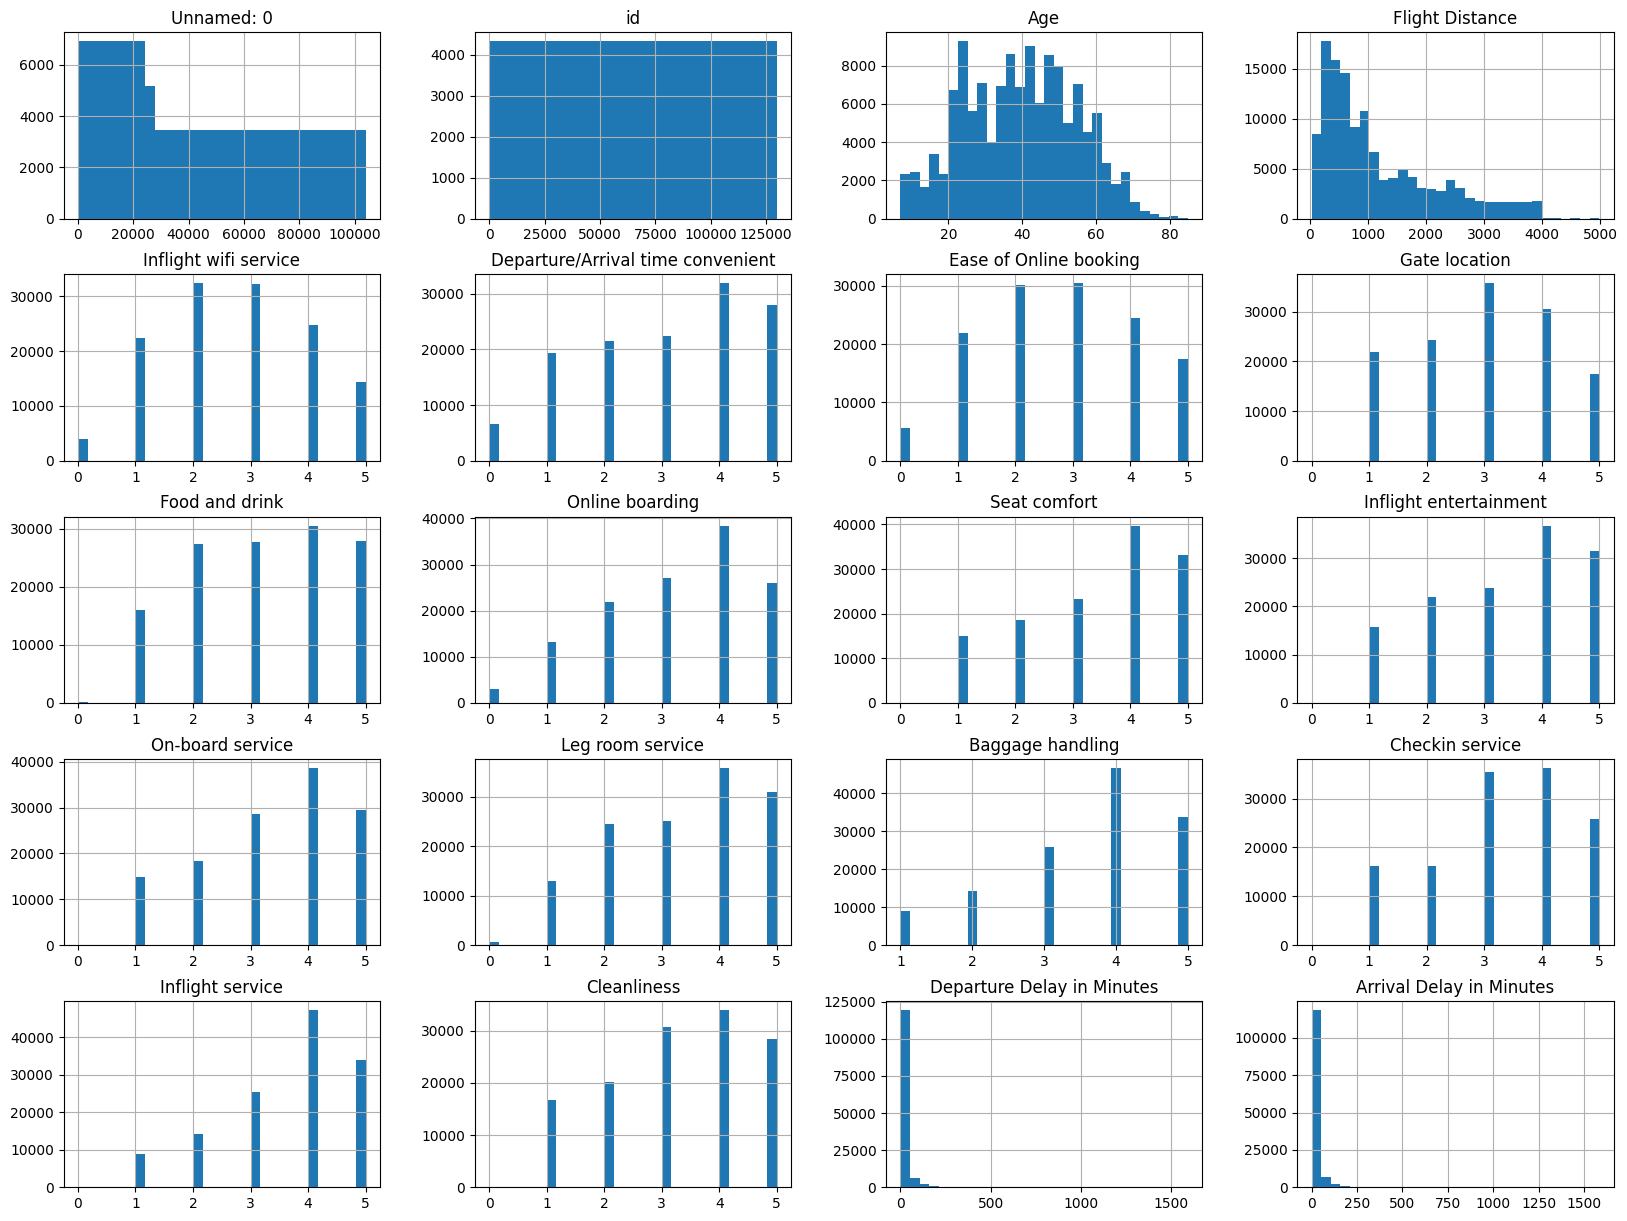

In [24]:
df.hist(bins = 30, figsize = (20,15))
plt.show()

In [25]:
correlationDF = df.select_dtypes(exclude=['object'])
correlationMatrix = correlationDF.corr()
correlationMatrix.style.background_gradient(cmap='coolwarm')

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
Unnamed: 0,1.000000,0.002199,0.000109,0.001160,-0.001320,0.002141,0.001388,0.003799,-0.004171,-0.000912,-0.001724,0.000485,0.000170,0.003046,-0.000626,-0.004747,-0.001990,-0.001083,0.002358,0.002099
id,0.002199,1.000000,0.020322,0.095504,-0.023096,-0.002192,0.013400,-0.000113,-0.000510,0.055538,0.052164,0.001620,0.055502,0.044088,0.074569,0.079325,0.078793,0.024048,-0.017643,-0.035657
Age,0.000109,0.020322,1.000000,0.099459,0.016116,0.036960,0.022565,-0.000398,0.023194,0.207572,0.159136,0.074947,0.057078,0.039119,-0.047991,0.033475,-0.051347,0.052565,-0.009041,-0.011248
Flight Distance,0.001160,0.095504,0.099459,1.000000,0.006701,-0.018914,0.065165,0.005520,0.057066,0.214825,0.157662,0.130507,0.111194,0.134533,0.064855,0.073608,0.059316,0.095648,0.002402,-0.001935
Inflight wifi service,-0.001320,-0.023096,0.016116,0.006701,1.000000,0.344915,0.714807,0.338573,0.132214,0.457445,0.121513,0.207802,0.119928,0.160317,0.120376,0.043762,0.110029,0.131300,-0.015946,-0.017749
Departure/Arrival time convenient,0.002141,-0.002192,0.036960,-0.018914,0.344915,1.000000,0.437620,0.447510,0.000687,0.072287,0.008666,-0.008380,0.067297,0.010617,0.070833,0.091132,0.072195,0.009862,0.000778,-0.000942
Ease of Online booking,0.001388,0.013400,0.022565,0.065165,0.714807,0.437620,1.000000,0.460041,0.030514,0.404866,0.028561,0.046564,0.039064,0.109450,0.039148,0.008819,0.035373,0.015125,-0.005318,-0.007033
Gate location,0.003799,-0.000113,-0.000398,0.005520,0.338573,0.447510,0.460041,1.000000,-0.002872,0.002756,0.002788,0.002741,-0.029019,-0.005181,0.000972,-0.039353,0.000310,-0.005918,0.005973,0.005658
Food and drink,-0.004171,-0.000510,0.023194,0.057066,0.132214,0.000687,0.030514,-0.002872,1.000000,0.233500,0.575846,0.623461,0.057404,0.033173,0.035321,0.085198,0.035210,0.658054,-0.029164,-0.031715
Online boarding,-0.000912,0.055538,0.207572,0.214825,0.457445,0.072287,0.404866,0.002756,0.233500,1.000000,0.419253,0.283922,0.154242,0.123225,0.083541,0.204238,0.074058,0.329377,-0.019404,-0.022730


In [26]:
# Encode the object columns for use in the correlation matrix
df['satisfaction'] = df['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1})
df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1})
df['Customer Type'] = df['Customer Type'].replace({'disloyal Customer': 0, 'Loyal Customer': 1})
df['Type of Travel'] = df['Type of Travel'].replace({'Business travel': 0, 'Personal Travel': 1})
df['Class'] = df['Class'].replace({'Eco': 0, 'Eco Plus': 1, 'Business': 2})

In [27]:
# Determine if gender has a noticeable effect on the satisfaction feature
import plotly.express as plot

# Calculate the satisfaction ratings given by each gender
gender_satisfaction = df.groupby('Gender')['satisfaction'].mean().reset_index()
gender_satisfaction.columns = ['Gender', 'Satisfaction Rate']

# Create a bar chart to graph the satisfaction rating for each gender
gender_bar = plot.bar(gender_satisfaction, x='Gender', y='Satisfaction Rate', color='Gender',
                 text='Satisfaction Rate',
                 labels={'Gender': 'Gender', 'Satisfaction Rate': 'Satisfaction Rate'},
                 title='Satisfaction Rate for each Gender')

gender_bar.show()

In [28]:
# Determine if age has a noticeable effect on the satisfaction feature

# Create age groups to group all of the passengers in
# The age groups will be graphed to show if certain age groups were more satisfied on average than others
bin_edges = [0, 18, 30, 45, 65, float('inf')]
bin_labels = ['0-18', '19-30', '31-45', '46-65', '66+']

df['Age Group'] = pd.cut(df['Age'], bins=bin_edges, labels=bin_labels, right=False)

# Calculate the satisfaction ratings given by each age group
age_group_satisfaction = df.groupby('Age Group')['satisfaction'].mean().reset_index()
age_group_satisfaction.columns = ['Age Group', 'Satisfaction Rate']

# Create a bar chart to graph the satisfaction rating for each age group
age_group_bar = plot.bar(age_group_satisfaction, x='Age Group', y='Satisfaction Rate',
                      text='Satisfaction Rate',
                      labels={'Age Group': 'Group', 'Satisfaction Rate': 'Satisfaction Rate'},
                      title='Satisfaction Rate by Age Group')

# Show the bar chart for Age Groups
age_group_bar.show()

# Drop the Age Group column before continuing
df = df.drop('Age Group', axis=1)
df = df.drop(columns=['Unnamed: 0', 'id'])
df.dropna(axis=0, inplace=True)

In [29]:
# Start to build models and evaluate them

# First, we need to split the data
from sklearn.model_selection import train_test_split
x = df.drop('satisfaction', axis=1)
y = df['satisfaction']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=5)

In [30]:
# Now we can create the classifiers used for this dataset

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tabulate import tabulate

# Create a list of classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Multi-layer Perceptron", MLPClassifier()),
]

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["Classifier", "Balanced Accuracy", "Training Accuracy", "Testing Accuracy", "F1 Score", "Precision", "Recall"])

# Train and evaluate each classifier
for name, clf in classifiers:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_prob = clf.predict_proba(x_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    accuracy_train = accuracy_score(y_train, clf.predict(x_train))
    accuracy_test = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
        
    results_df = pd.concat([results_df,pd.DataFrame({
        "Classifier": [name],
        "Balanced Accuracy": [auc_score],
        "Training Accuracy": [accuracy_train],
        "Testing Accuracy": [accuracy_test],
        "F1 Score": [f1],
        "Precision": [precision],
        "Recall": [recall]
    })], ignore_index=True)

# Sort the DataFrame by Balanced Accuracy in descending order
results_df = results_df.sort_values(by="Balanced Accuracy", ascending=False)

# Print the results table with styling
styled_results = results_df.style.background_gradient(cmap='Blues', subset=["Balanced Accuracy", "Training Accuracy", "Testing Accuracy", "F1 Score", "Precision", "Recall"])
styled_results = styled_results.hide()

styled_results

Classifier,Balanced Accuracy,Training Accuracy,Testing Accuracy,F1 Score,Precision,Recall
Random Forest,0.993469,1.000000,0.961850,0.955790,0.972678,0.939479
Multi-layer Perceptron,0.982276,0.932286,0.930248,0.918964,0.937674,0.900985
Decision Tree,0.944836,1.000000,0.945292,0.937897,0.934717,0.941098
Logistic Regression,0.858918,0.799279,0.794020,0.775669,0.743071,0.811260
K-Nearest Neighbors,0.809459,0.835134,0.752533,0.705835,0.738002,0.676355
